# Расчет проводимости трубопроводов с помощью МУК

In [1]:
import os
import math
import numpy as np
from graph import Graph #собственный класс для графиков
from matplotlib import pyplot as plt

## Прямоугольное сечение

### Угловые коэффициенты

In [2]:
def scalar_prod(v_1, v_2):
    v_1 , v_2 = np.array(v_1), np.array(v_2)
    return (v_1*v_2).sum()

def module(v):
    return math.sqrt( scalar_prod(v, v) )

def elementary(center_i : list, center_j : list, normal_i : list, normal_j : list, F_j):
    #F_j - площадь одной ячейки коллектора.
    center_i, center_j = np.array(center_i), np.array(center_j)
    
    r        = module(center_i - center_j)
    n_i, n_j = module(normal_i), module(normal_j)
    
    cos_1 = abs( scalar_prod( normal_i, center_j - center_i ) ) / (r*n_i)
    cos_2 = abs( scalar_prod( normal_j, center_i - center_j ) ) / (r*n_j)
    return cos_1*cos_2/(math.pi*r**2)*F_j

In [3]:
def local(center_i, centers_2, normal_i, normal_j, F_j):
    return sum([ elementary(center_i, center, normal_i, normal_j, F_j) for center in centers_2])

def emitter_to_collector(centers_1, centers_2,normal_1, normal_2, F_i, F_j):
    #F_i - площадь одной ячейки эмиттера.
    return sum( [ local(center, centers_2, normal_1, normal_2, F_j) for center in centers_1 ] ) * F_i

### Разбиение

In [4]:
def euclid(num_1, num_2):
    while num_1 != num_2:
        if num_1 > num_2:
            num_1 -= num_2
        else:
            num_2 -= num_1
    return num_1

#ф-ция находит минимальное количество квадратов
#с одинаковой площадью, на которое можно разбить
#данный прямоугольник
def search_squares(a : int, b : int) -> int:
    gcd = euclid(a,b) #НОД
    return a*b/gcd

#ф-ция ищет оптимальное кол-во квадратов 
#в зависимости от введенного кол-ва
def optimal_squares(a, b, num):
    min_num = search_squares(a,b)
    n       = num//(4*min_num)
    return min_num if n == 0 else 4*min_num*n

In [5]:
#функции разбиения каждой отдельной поверхности на ячейки.
#1-входное, 2-выходное сечения.
#3-верхняя, 5-нижняя грани.
#если смотреть в направлении от 1 к 2, то
#3,4,5 и 6 грани пронумерованы по часовой стрелке.
def breaking_1(a, b, num, s = 0) -> list:
    #a - вдоль x, b - вдоль z, s - вдоль y
    num = optimal_squares(a,b,num)
    
    square_side = math.sqrt(a*b/num)
    l_1 = int(a/square_side)
    l_2 = int(b/square_side)
    res = []
    for i in range(l_1):
        x = a/(2*l_1) + a/l_1*i
        for j in range(l_2):
            z = b/(2*l_2) + b/l_2*j
            center = [x,0,z]
            res.append(center)
    return res,num

def breaking_2(a, b, num, s) -> list:
    res = []
    num = optimal_squares(a,b,num)
    
    square_side = math.sqrt(a*b/num)
    l_1 = int(a/square_side)
    l_2 = int(b/square_side)
    for i in range(l_1):
        x = a/(2*l_1) + a/l_1*i
        for j in range(l_2):
            z = b/(2*l_2) + b/l_2*j
            center = [x,s,z]
            res.append(center)
    return res,num

def breaking_3(a, b, num, s) -> list:
    res = []
    num = optimal_squares(a,s,num)
    
    square_side = math.sqrt(a*s/num)
    l_1 = int(a/square_side)
    l_2 = int(s/square_side)
    for i in range(l_1):
        x = a/(2*l_1) + a/l_1*i
        for j in range(l_2):
            y = s/(2*l_2) + s/l_2*j
            center = [x,y,b]
            res.append(center)
    return res,num

def breaking_4(a, b, num, s) -> list:
    res = []
    num = optimal_squares(s,b,num)
    
    square_side = math.sqrt(s*b/num)
    l_1 = int(s/square_side)
    l_2 = int(b/square_side)
    for i in range(l_1):
        y = s/(2*l_1) + s/l_1*i
        for j in range(l_2):
            z = b/(2*l_2) + b/l_2*j
            center = [0,y,z]
            res.append(center)
    return res,num

def breaking_5(a, b, num, s) -> list:
    res = []
    num = optimal_squares(a,s,num)
    
    square_side = math.sqrt(a*s/num)
    l_1 = int(a/square_side)
    l_2 = int(s/square_side)
    for i in range(l_1):
        x = a/(2*l_1) + a/l_1*i
        for j in range(l_2):
            y = s/(2*l_2) + s/l_2*j
            center = [x,y,0]
            res.append(center)
    return res,num

def breaking_6(a, b, num, s) -> list:
    res = []
    num = optimal_squares(s,b,num)
    
    square_side = math.sqrt(s*b/num)
    l_1 = int(s/square_side)
    l_2 = int(b/square_side)
    for i in range(l_1):
        y = s/(2*l_1) + s/l_1*i
        for j in range(l_2):
            z = b/(2*l_2) + b/l_2*j
            center = [a,y,z]
            res.append(center)
    return res,num

In [6]:
#площади "уникальных" поверхностей - area_1 == area_2 итд
def area_1(a, b, s):
    return a*b

def area_3(a, b, s):
    return a*s

def area_4(a, b, s):
    return s*b

### Проводимость

In [7]:
#ф-ция, заменяющаяя столбец матрицы
def change_column(A, j : int = 0):
    #A - матрица
    #j - номер изменяемого столбца
    new_A = A.copy()
    for i in range(len(new_A)):
        if i:
            new_A[i][j] = 0
        else:
            new_A[i][j] = -1
    return new_A

In [8]:
class Rectangular:
    def __init__(self, a, b, L):
        self.a = a
        self.b = b
        self.L = L
        self.normals  = [ [0,1,0], [0,1,0], [0,0,1], [1,0,0], [0,0,1], [1,0,0] ]
        self.breaking = [ breaking_1, breaking_2, breaking_3, breaking_4, breaking_5, breaking_6 ]
        self.areas    = [ area_1, area_1, area_3, area_4, area_3, area_4 ]
        for i in range(6):
            self.areas[i] = self.areas[i](a,b,L)
        return
    
    def some_pair(self, i, j, num_1, num_2):
        #i - номер эмиттера   от 1 до 6.
        #j - номер коллектора от 1 до 6.
        #num_1, num_2 - на сколько частей разбить
        #эмиттер и коллектор соответсвенно.
        i-=1 #это - номер эмиттера   в массивах.
        j-=1 #это - номер коллектора в массивах.
        
        #параметры коллектора:
        #num_j - число квадратов, на которое 
        #удалось разделить коллектор в итоге
        collector, num_j = self.breaking[j](self.a,self.b,num_2,self.L)
        normal_j= self.normals[j]
        cell_j  = self.areas[j]/num_j
        
        #параметры эмиттера:
        #num_i - число квадратов, на которое 
        #удалось разделить эмиттер в итоге
        emitter, num_i = self.breaking[i](self.a,self.b,num_1,self.L)
        normal_i= self.normals[i]
        area_i  = self.areas[i]
        cell_i  = area_i/num_i
        return emitter_to_collector(emitter,collector,normal_i,normal_j,cell_i,cell_j)/area_i
    
    def matrix(self, num_1, num_2):
        res  = []    #будущая матрица УК
        line = [0]*7 #текущий столбец матрицы
        #т.к. УК вида phi_21, phi_31, ..., phi_61
        #не используются в дальнейшем
        for j in range(1,7):
            #благодаря симметрии УК для граней 5 и 6
            #в качестве коллекторов можно не считать,
            #симметрия учтена при решении системы ур-ний 2.1
            res.append(line)
            line = []
            for i in range(7):
                if i:
                    if i == j:
                        line.append(0)
                    else:
                        line.append(self.some_pair(i,j,num_1,num_2))
                else:
                    line = [0]
        res.append(line)
        #транспонируем, чтобы можно было 
        #найти phi_ij = matrix[i][j],
        #а не  phi_ij = matrix[j][i]
        return np.transpose(np.array(res))
    
    def clausing(self, num_1 = 10, num_2 = 10):
        phi = self.matrix(num_1, num_2)
        #СЛУ
        sle = [    [-1,        phi[2][1],  2*phi[3][1],  2*phi[4][1]]]
        sle.append([phi[1][2], -1,         2*phi[3][2],  2*phi[4][2]])
        sle.append([phi[1][3], phi[2][3], -1+phi[5][3],  2*phi[4][3]])
        sle.append([phi[1][4], phi[2][4],  2*phi[3][4], -1+phi[6][4]])
        sle   = np.array(sle)
        delta = np.linalg.det(sle)
        q     = []
        #метод Крамера
        for j in range(4):
            new_sle = change_column(sle, j)
            delta_j = np.linalg.det(new_sle)
            q.append(delta_j/delta)
        res = phi[1][2]*q[0]
        res+= 2*phi[3][2]*q[2]
        res+= 2*phi[4][2]*q[3]
        return res

### Тестирование

In [9]:
#тесты на сами УК
def test_1(phi):
    #вывод всех пар УК
    for i in range(1,len(phi)):
        for j in range(1,len(phi[i])):
            print("phi_" + str(i)+str(j) + " =", phi[i][j])
    print("\n")
    return

def test_2(phi):
    #свойство замкнутости
    for i in range(1,len(phi)):
        sum = 0
        for j in range(1, len(phi[i])):
            sum += phi[i][j]
        if round(1 - sum,5) != 0:
                print("Свойство замкнутости не выполнено для i =", i)
    print("Проверка на замкнутость закончена \n")
    return

def test_3(t, num_1 = 10, num_2 = 10):
    #свойство взаимности
    phi = t.matrix(num_1, num_2)
    for i in range(1, len(phi)):
        for j in range(1, len(phi[i])):
            if round(phi[i][j] * t.areas[i-1],5) != round(phi[j][i] * t.areas[j-1],5):
                print("Свойство взаимности не выполнено для i =", i, "и j =", j)
    print("Проверка на взаимность закончена \n")   
    return

In [10]:
tube_1, tube_2 = Rectangular(1,1,1), Rectangular(1,5,1)
phi_1,  phi_2  = tube_1.matrix(100,100), tube_2.matrix(100,100)

In [11]:
print("phi для a = 1, b = 1, L = 1:")
test_1(phi_1)
print("phi для a = 1, b = 5, L = 1:")
test_1(phi_2)

phi для a = 1, b = 1, L = 1:
phi_11 = 0.0
phi_12 = 0.20042981274394034
phi_13 = 0.21343962958951387
phi_14 = 0.21343962958951387
phi_15 = 0.2134396295895138
phi_16 = 0.21343962958951396
phi_21 = 0.20042981274394034
phi_22 = 0.0
phi_23 = 0.21343962958951396
phi_24 = 0.213439629589514
phi_25 = 0.2134396295895139
phi_26 = 0.21343962958951404
phi_31 = 0.2134396295895139
phi_32 = 0.21343962958951396
phi_33 = 0.0
phi_34 = 0.21343962958951399
phi_35 = 0.20042981274394034
phi_36 = 0.2134396295895141
phi_41 = 0.21343962958951387
phi_42 = 0.21343962958951396
phi_43 = 0.21343962958951385
phi_44 = 0.0
phi_45 = 0.21343962958951376
phi_46 = 0.20042981274394034
phi_51 = 0.2134396295895138
phi_52 = 0.21343962958951387
phi_53 = 0.20042981274394034
phi_54 = 0.2134396295895139
phi_55 = 0.0
phi_56 = 0.21343962958951399
phi_61 = 0.213439629589514
phi_62 = 0.21343962958951404
phi_63 = 0.21343962958951396
phi_64 = 0.20042981274394034
phi_65 = 0.2134396295895139
phi_66 = 0.0


phi для a = 1, b = 5, L = 1:
phi

In [12]:
test_2(phi_1)
test_2(phi_2)

Свойство замкнутости не выполнено для i = 1
Свойство замкнутости не выполнено для i = 2
Свойство замкнутости не выполнено для i = 3
Свойство замкнутости не выполнено для i = 4
Свойство замкнутости не выполнено для i = 5
Свойство замкнутости не выполнено для i = 6
Проверка на замкнутость закончена 

Свойство замкнутости не выполнено для i = 1
Свойство замкнутости не выполнено для i = 2
Свойство замкнутости не выполнено для i = 3
Свойство замкнутости не выполнено для i = 4
Свойство замкнутости не выполнено для i = 5
Свойство замкнутости не выполнено для i = 6
Проверка на замкнутость закончена 



In [13]:
test_3(tube_1)
test_3(tube_2)

Проверка на взаимность закончена 

Проверка на взаимность закончена 



In [14]:
#тесты  на коэффициент Клаузинга
def test_4(t, num_1 = 100, num_2 = 100):
    #меньше ли 1
    print("Коэффициент Клаузинга меньше единицы", t.clausing(num_1,num_2) <= 1)
    print("\n")
    return

def test_5(t, num_1 = 100, num_2 = 100):
    #больше ли 0
    print("Коэффициент Клаузинга больше нуля", t.clausing(num_1,num_2) >= 0)
    print("\n")
    return

In [15]:
test_4(tube_1)
test_4(tube_2)

Коэффициент Клаузинга меньше единицы True


Коэффициент Клаузинга меньше единицы False




In [16]:
test_5(tube_1)
test_5(tube_2)

Коэффициент Клаузинга больше нуля False


Коэффициент Клаузинга больше нуля True




In [17]:
#тесты элементарного УК
def angles(num = 5):
    #зависимость элементарного УК от угла
    c_i = [1/2, 0, 1/2]
    c_j = [1/2, 1, 1/2]
    n_i = [0,1,0]
    angle_ar = np.linspace(0,1,num)*math.pi
    
    x, y = np.sin(angle_ar), np.cos(angle_ar)
    Y    = []
    for i in range(num):
        n_j = [x[i], y[i], 0]
        X   = angle_ar/math.pi*180
        Y.append(elementary(c_i,c_j,n_i,n_j,0.05))
    
    graph = Graph()
    graph.customize_graph("Зависимость  элем-го УК от угла", "Угол в градусах")
    plt.plot(X,Y, marker="o")
    graph.save("angle.png", "tests")
    return

def distance(num = 5):
    #зависимость  элем-го УК от расстояния
    c_i  = [1/2, 0, 1/2]
    n_i  = [0,1,0]
    n_j  = [np.sin(math.pi/4), np.cos(math.pi/4),0]
    dist = np.linspace(0,10,num)
    Y    = []
    for d in dist:
        c_j = c_j = [1/2, d, 1/2]
        Y.append(elementary(c_i,c_j,n_i,n_j,0.05))
        
    graph = Graph()
    graph.customize_graph("Зависимость  элем-го УК от расстояния", "Расстояние")
    plt.plot(dist,Y, marker="o")
    graph.save("distance.png", "tests")
    return

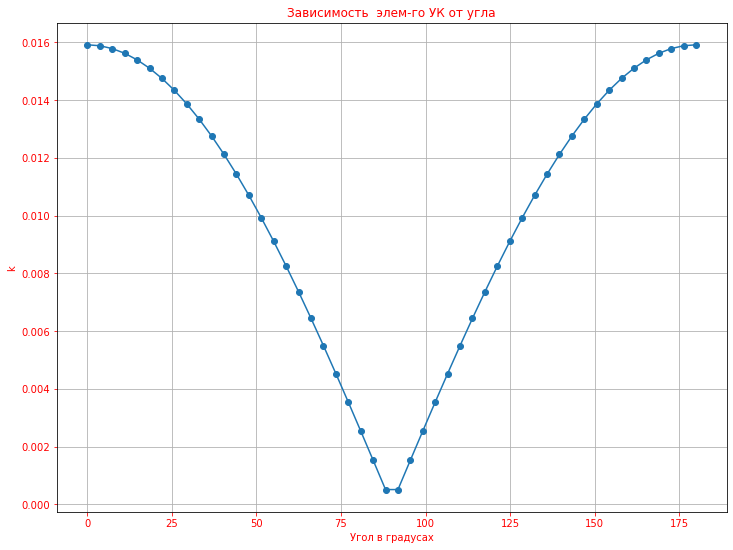

In [18]:
angles(50)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_8924/1963656057.py:15: RuntimeWarning: invalid value encountered in double_scalars
  cos_1 = abs( scalar_prod( normal_i, center_j - center_i ) ) / (r*n_i)
C:\Users\ASUS\AppData\Local\Temp/ipykernel_8924/1963656057.py:16: RuntimeWarning: invalid value encountered in double_scalars
  cos_2 = abs( scalar_prod( normal_j, center_i - center_j ) ) / (r*n_j)


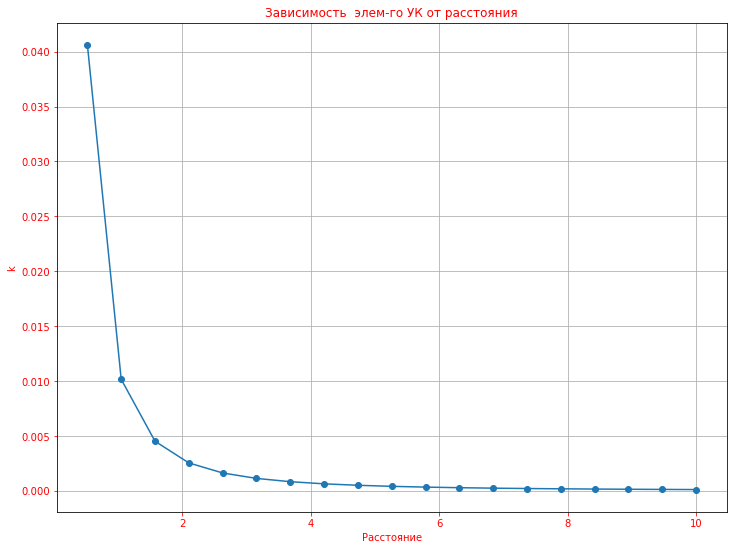

In [19]:
distance(20)

### Графики

In [21]:
#ф-ция строит кривую на графике
#и сохраняет его
def lines(x, k, filename = "", dirname = ""):
    plt.scatter(x, k, marker="o")
    plt.plot(x, k)
    
    plt.legend()
    Graph().save(filename, dirname)
    return

#ф-ция строит, называет,
#выводит и сохраняет 2 графика
#для разных прямоугольных сечений
def draw(num_1 = 10, num_2 = 10):
    x   = range(1,11)
    k_1 = [Rectangular(1,1,element).clausing(num_1, num_2) for element in x]
    
    graph = Graph()
    graph.customize_graph("Проводимость в прямоугольном сечении при b = 1", "L")
    lines(x, k_1, "b1.png", "rectangular")
    plt.show()
    
    k_2 = [Rectangular(1,5,element).clausing(num_1, num_2) for element in x]
    graph.customize_graph("Проводимость в прямоугольном сечении при b = 5", "L")
    lines(x, k_2, "b5.png", "rectangular")
    plt.show()
    return

No handles with labels found to put in legend.


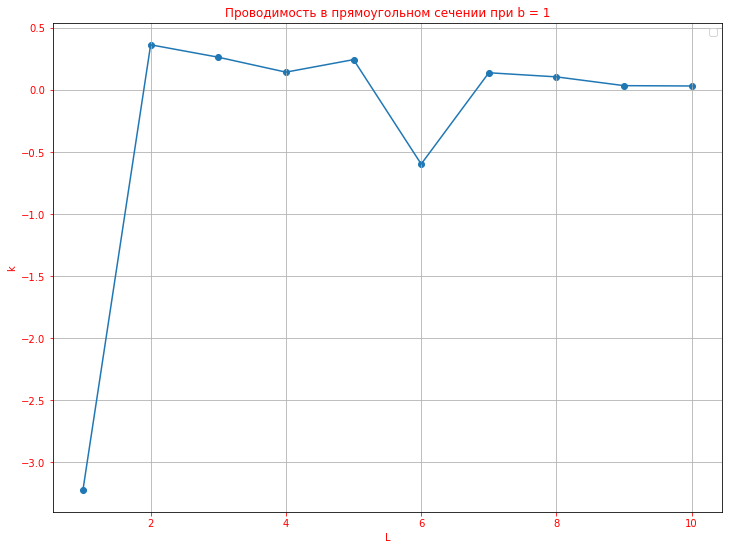

No handles with labels found to put in legend.


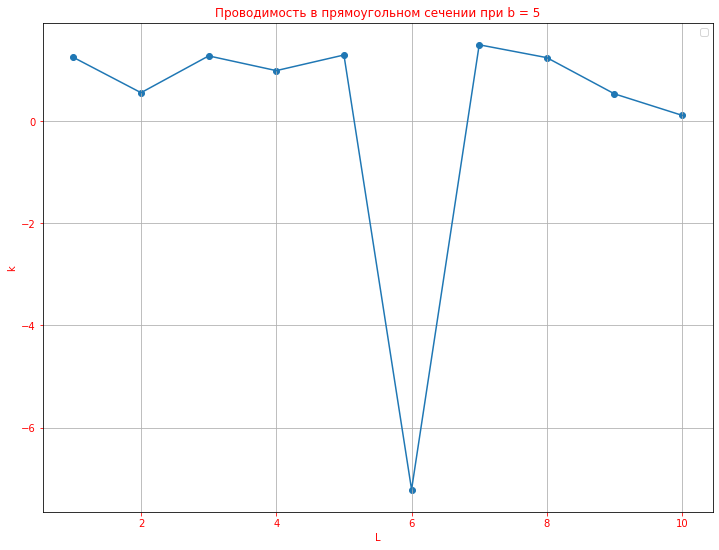

In [22]:
draw(100,100)